In [1]:
#Import required libraries
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters, exposure

In [2]:
image1 = cv.imread('image1.jpg',1)
image2 = cv.imread('image2.jpg',1)
chestxray = cv.imread('chestxray.png',0)
hawkbay = cv.imread('HawkesBay.jpg',0)
crayons = cv.imread('crayons.jpg',1)

#Converting from BGR to RGB for CT
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
crayons = cv.cvtColor(crayons, cv.COLOR_BGR2RGB)

### 1.

In [3]:
def hist_equalization(image):
    
    # extracting bin information
    hist,bins = np.histogram(image.flatten(),256,[0,256])
    
    # computing the cumulative sums
    cdf = hist.cumsum()
    
    # normalizing the cumulative sums
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    
    # returning the histogram equalized image
    return cdf[image], cdf[list(range(0,255))]

In [4]:
def imhist(im):
    # calculates normalized histogram of an image
    m, n = im.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[im[i, j]]+=1
    return np.array(h)/(m*n)

def cumsum(h):
    # finds cumulative sum of a numpy array, list
    return [sum(h[:i+1]) for i in range(len(h))]

# Histogram equalization function
def hist_equalization(im):
    h = imhist(im)
    cdf = np.array(cumsum(h)) #cumulative distribution function
    sk = np.uint8(255 * cdf) #finding transfer function values
    s1, s2 = im.shape
    Y = np.zeros_like(im)
    # applying transfered values for each pixels
    for i in range(0, s1):
        for j in range(0, s2):
            Y[i, j] = sk[im[i, j]]
    H = imhist(Y)
    
    #return transformed image, original and new histogram, and transform function
    return Y , sk

In [5]:
equal_hawk, int_trans_hawk = hist_equalization(hawkbay)
equal_chest, int_trans_chest = hist_equalization(chestxray)

Histogram equalization on Hawkes Bay(first row) and Chest X-ray(second row)


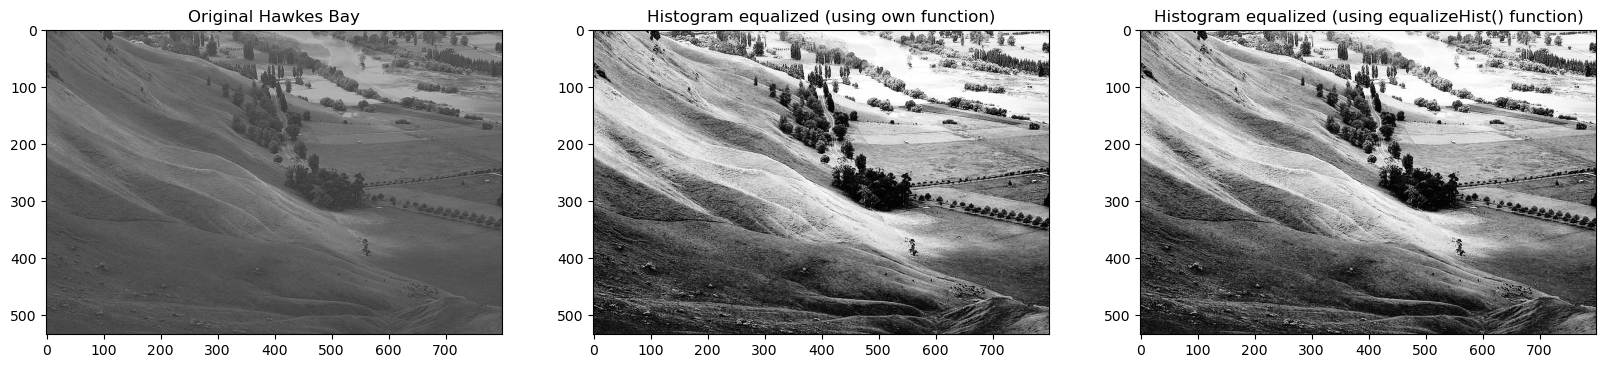

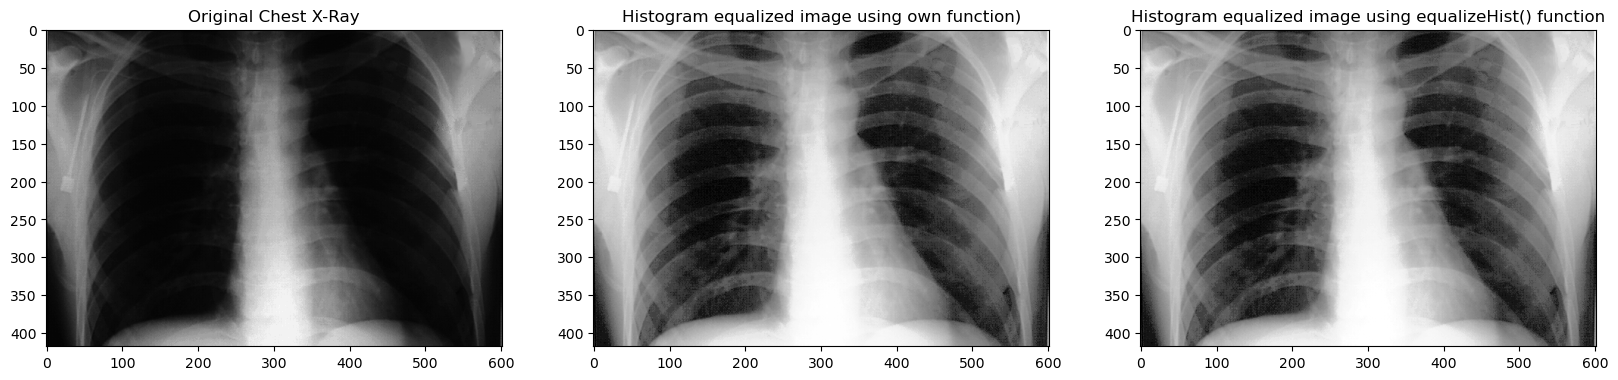

In [6]:
# Hawkesbay image
fig, axs = plt.subplots(1,3, figsize = (20, 10))
axs[0].imshow(hawkbay, cmap = 'gray')
axs[0].set_title('Original Hawkes Bay')

axs[1].imshow(equal_hawk, cmap = 'gray')
axs[1].set_title("Histogram equalized (using own function)")

axs[2].imshow(cv.equalizeHist(hawkbay), cmap = 'gray')
axs[2].set_title("Histogram equalized (using equalizeHist() function)")

print("Histogram equalization on Hawkes Bay(first row) and Chest X-ray(second row)")

# plt.suptitle("Hawkes Bay Histogram equalization")
fig, axs = plt.subplots(1,3, figsize = (20, 10))
axs[0].imshow(chestxray, cmap = 'gray')
axs[0].set_title('Original Chest X-Ray')

axs[1].imshow(equal_chest, cmap = 'gray')
axs[1].set_title("Histogram equalized image using own function)")

axs[2].imshow(cv.equalizeHist(chestxray), cmap = 'gray')
axs[2].set_title("Histogram equalized image using equalizeHist() function")

plt.show()

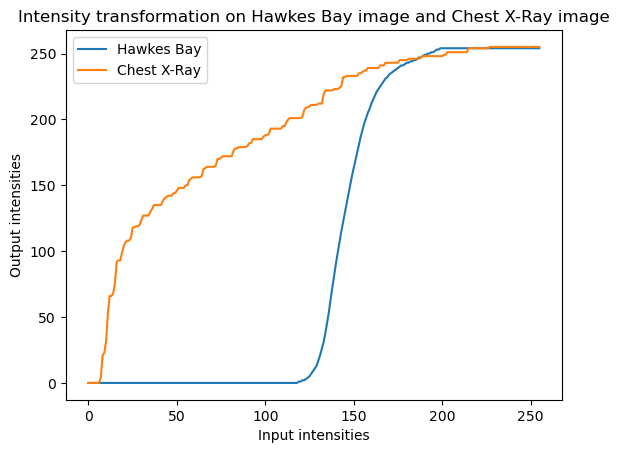

In [7]:
plt.plot(list(range(0,256)), int_trans_hawk)
plt.xlabel("Input intensities")
plt.ylabel("Output intensities")
plt.title("Intensity transformation on Hawkes Bay image and Chest X-Ray image")

# plotting the graph of actual vocabulary values and the estimated vocabulary values (Heap's law)
plt.plot(list(range(0,256)), int_trans_chest)
plt.legend(['Hawkes Bay', 'Chest X-Ray'])
plt.show()

We observe that the images look the same for both our own function and equalizeHist() function for both the images.

### 2.

In [8]:
# Extracting the colour channels of the 2 images
R_image1, G_image1, B_image1 = cv.split(image1)
R_image2, G_image2, B_image2 = cv.split(image2)

### a)

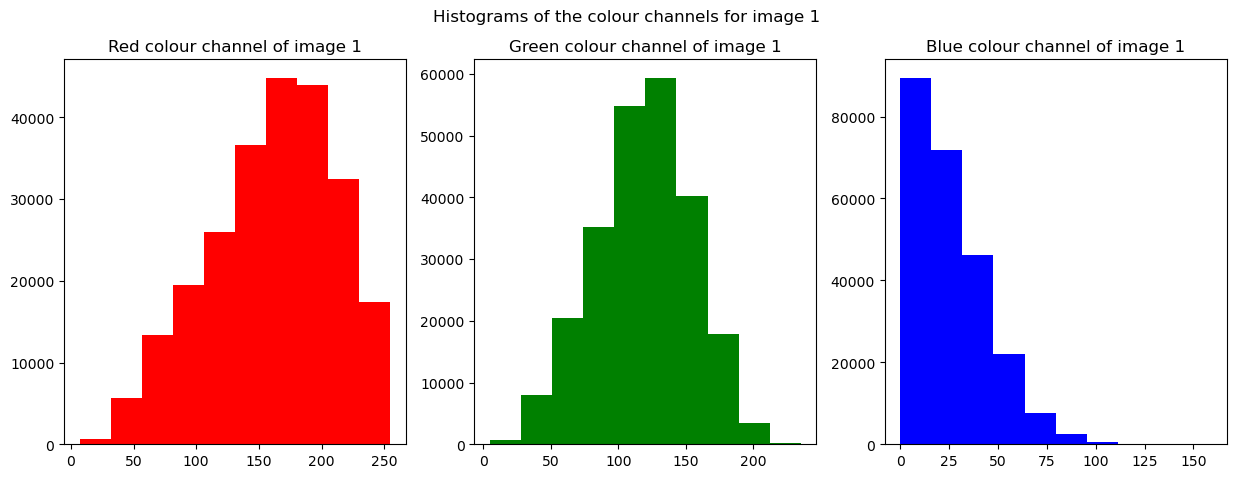

In [9]:
# Plotting the histograms  
fig, axs = plt.subplots(1,3, figsize = (15, 5))
axs[0].hist(R_image1.flatten(), color = 'r')
axs[0].set_title('Red colour channel of image 1')

axs[1].hist(G_image1.flatten(), color = 'g')
axs[1].set_title("Green colour channel of image 1")

axs[2].hist(B_image1.flatten(), color = 'b')
axs[2].set_title("Blue colour channel of image 1")

plt.suptitle("Histograms of the colour channels for image 1")

plt.show()

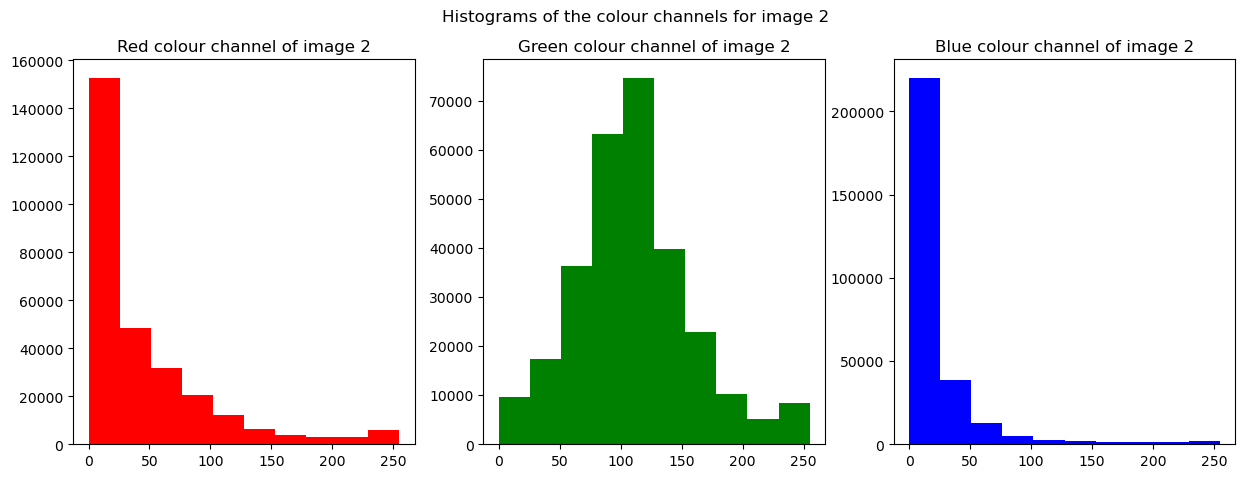

In [10]:
fig, axs = plt.subplots(1,3, figsize = (15, 5))

axs[0].hist(R_image2.flatten(), color = 'r')
axs[0].set_title("Red colour channel of image 2")

axs[1].hist(G_image2.flatten(), color = 'g')
axs[1].set_title("Green colour channel of image 2")

axs[2].hist(B_image2.flatten(), color = 'b')
axs[2].set_title("Blue colour channel of image 2")

plt.suptitle("Histograms of the colour channels for image 2")
plt.show()

### b)

In [11]:
# function to find the lowest intensity that matches
def find_nearest_above(my_array, target):
    diff = my_array - target
    mask = np.ma.less_equal(diff, -1)
    if np.all(mask):
        c = np.abs(diff).argmin()
        return c # returns min index of the nearest if target is greater than any value
    masked_diff = np.ma.masked_array(diff, mask)
    return masked_diff.argmin()

# Histogram matching
def match_histograms(src, dst):
 
    src_shape = src.shape
    src = src.ravel()
    dst = dst.ravel()
 
    # get the set of unique pixel values and their corresponding indices and counts
    s_values, bin_idx, s_counts = np.unique(src, return_inverse=True,return_counts=True)
    t_values, t_counts = np.unique(dst, return_counts=True)
 
    # Calculate s_k for source image
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    
    # Calculate s_k for destination image
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
 
    # Round the values
    sour = np.around(s_quantiles*255)
    temp = np.around(t_quantiles*255)
    
    # Map the rounded values
    matched_hist = list()
    for data in sour[:]:
        matched_hist.append(find_nearest_above(temp,data))
    matched_hist = np.array(matched_hist, dtype='uint8')
 
    return matched_hist[bin_idx].reshape(src_shape)

In [12]:
# Matching the histograms of the different colour channels separately and recombining
matched_R = match_histograms(R_image1, R_image2)
matched_G = match_histograms(G_image1, G_image2)
matched_B = match_histograms(B_image1, B_image2)
recombined = cv.cvtColor(cv.merge((matched_B, matched_G, matched_R)), cv.COLOR_BGR2RGB)

### c)

In [13]:
def compare_matched_hist(src,dst,matched_src):
    images = [src,dst,matched_src]
    headings = ["Original image1","Original image2","Image1 after histogram matching (ref:image2)"]
    n,m = len(images),2
    fig,ax = plt.subplots(n,m,figsize=(15,10))

    for i, (heading,img) in enumerate(zip(headings,images)):
        ax[i,0].imshow(img, cmap="gray")
        ax[i,0].axis('off')
        ax[i,0].set_title(heading)

        ax[i,1].hist(img.ravel(), bins=32, range=(0.0, 256.0), ec='k') #calculating histogram
    plt.show()

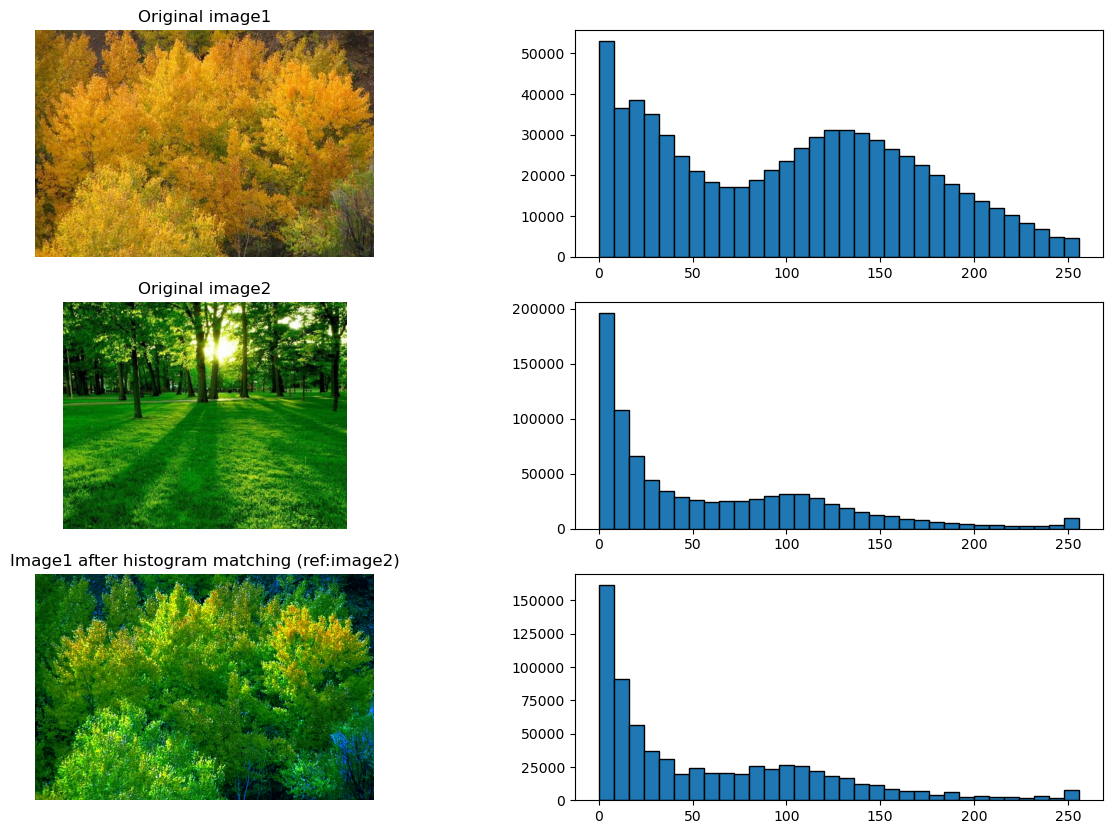

In [14]:
compare_matched_hist(image1, image2, recombined)

### d) 
The newly constructed image is greener and not yellowish like the original image. This is because of the fact that the blue and red colour channels of image2 are dominated significantly by the green colour channel values, as is evident from the histograms above. Thus when we apply histogram matching, we find that image1 has been made noticeably greener.

### 3.

### a)

In [15]:
# Splitting the colour channels
R, G, B = cv.split(crayons)

# Histogram equalization on each color channel
R_histequal = cv.equalizeHist(R)
G_histequal = cv.equalizeHist(G)
B_histequal = cv.equalizeHist(B)

# Merging the equalized channels
equal_crayons =  cv.cvtColor(cv.merge((B_histequal, G_histequal, R_histequal)), cv.COLOR_BGR2RGB)

Histogram equalization on Crayons for every colour channel


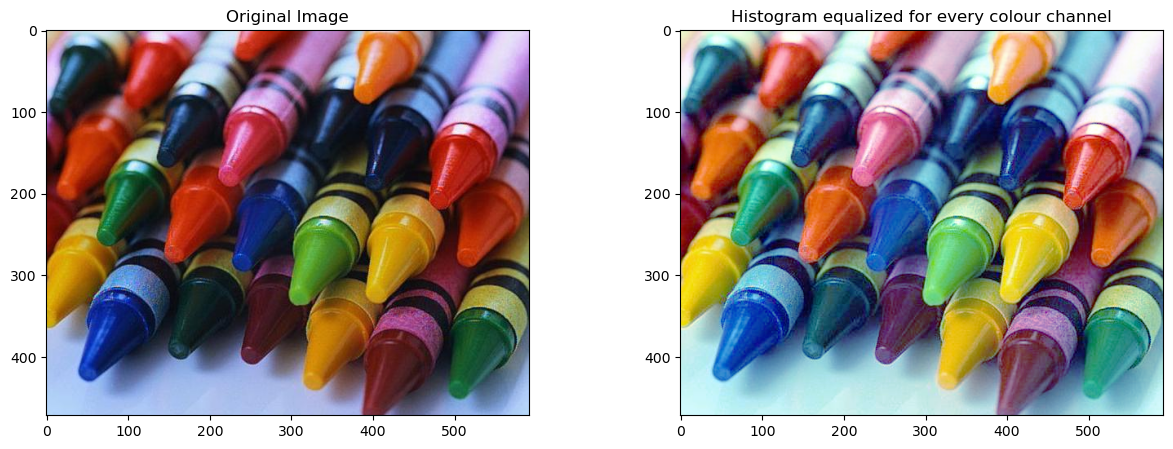

In [16]:
fig, axs = plt.subplots(1,2, figsize = (15, 5))

axs[0].imshow(crayons)
axs[0].set_title('Original Image')

axs[1].imshow(equal_crayons)
axs[1].set_title("Histogram equalized for every colour channel")


print("Histogram equalization on Crayons for every colour channel")
plt.show()

### b)

In [17]:
# Converting to HSV space
crayons_hsv = cv.cvtColor(crayons, cv.COLOR_RGB2HSV)

# Splitting the color channels
h, s, v = cv.split(crayons_hsv)

# Histogram equalization on V channel
v_histequal = cv.equalizeHist(v)

# Merging the channels again
final_crayons = cv.cvtColor(cv.merge((h, s, v_histequal)), cv.COLOR_HSV2RGB)

Histogram equalization on Crayons only on V colour channel


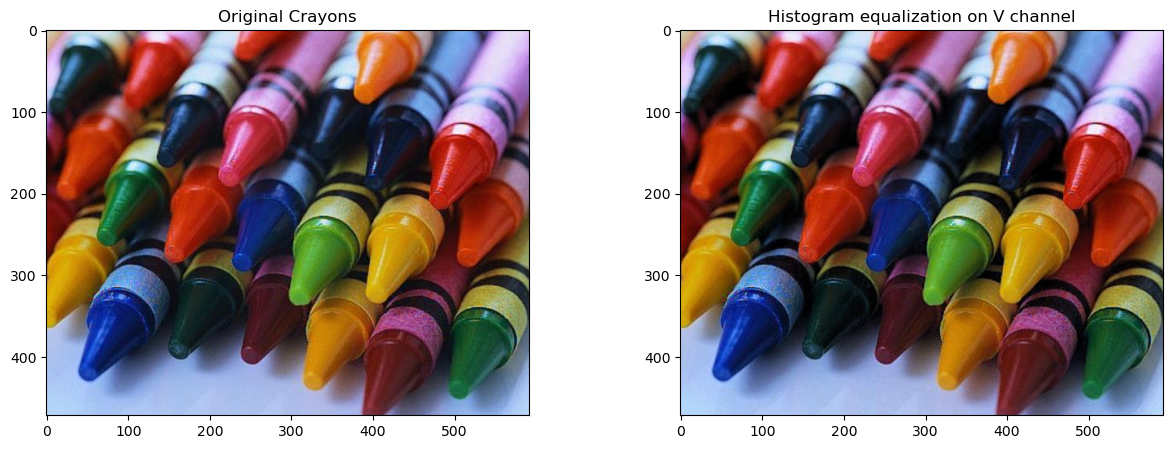

In [18]:
fig, axs = plt.subplots(1,2, figsize = (15, 5))
axs[0].imshow(crayons)
axs[0].set_title('Original Crayons')

axs[1].imshow(final_crayons)
axs[1].set_title("Histogram equalization on V channel")


print("Histogram equalization on Crayons only on V colour channel")
plt.show()

### c) 
We observe that on applying histogram equalization on all three channels (R, G, B) and combining their respective histogram equalized colour channels, the colours become slightly lighter compared to original image. Also there is difference between the colours present in the original image and those in the transformed image. However, when the original image is transformed to the HSV space and the histogram of the V channel is equalized and merged with the original H and S channels, the image we get is very close to original image.

### 4.

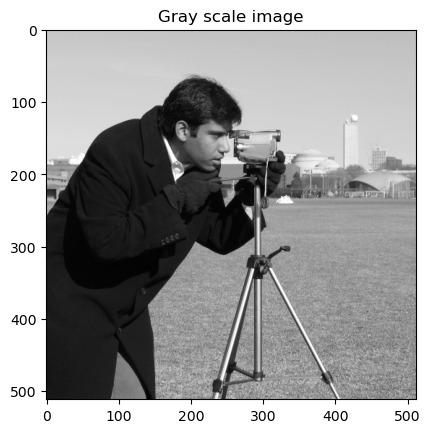

In [19]:
image = data.camera()

plt.imshow(image, cmap = 'gray')
plt.title('Gray scale image')
plt.show()

### a) 
The user may choose any window as per requirements by entering the start and end values of x and y respectively when prompted. Here, for illustration purposes I have selected the entire image.

In [20]:
# Choosing the neighbourhood size and the region to perform SWAHE

# Neighbourhood size (odd):
k = 5

# x bounds:
x_initial = 0
x_final = 512

# y bounds:
y_initial = 0
y_final = 512

### b)

In [21]:
# To store the image as a result of SWAHE
result = image.copy()

for i in range(x_initial, x_final - k):
    for j in range(y_initial, y_final-k):
        result[i:i+k, j:j+k] = cv.equalizeHist(result[i:i + k, j:j + k].copy())

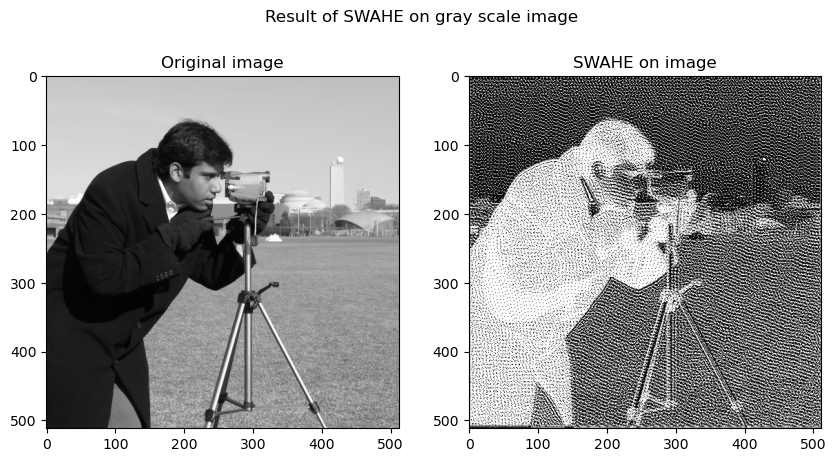

In [22]:
# Displaying the result due to SWAHE
fig, axs = plt.subplots(1,2, figsize = (10, 5))
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title('Original image')

axs[1].imshow(result, cmap = 'gray')
axs[1].set_title("SWAHE on image")

plt.suptitle("Result of SWAHE on gray scale image")
plt.show()

### c)

In [23]:
# Choosing the neighbourhood size and the region to perform AHE

# Neighbourhood size (odd):
k = 100

# x bounds:
x_initial = 0
x_final = 512

# y bounds:
y_initial = 0
y_final = 512

In [24]:
# to store the image as a result of AHE
result = image.copy()
        
for i in range(x_initial, x_final - k):
    for j in range(y_initial, y_final-k):
        result[i:(i+k), j:(j+k)] = cv.equalizeHist(result[i:(i + k), j:(j + k)].copy())

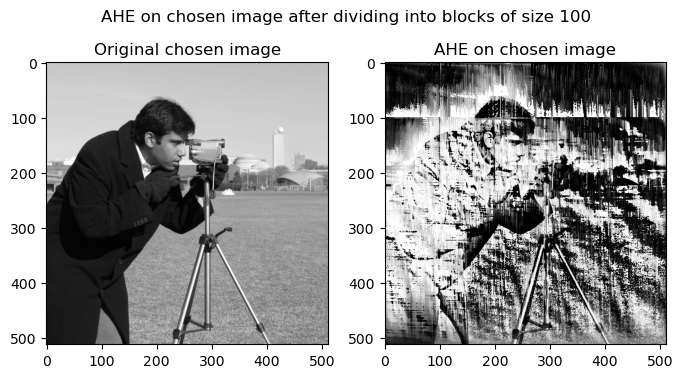

In [25]:
fig, axs = plt.subplots(1,2, figsize = (8, 4))
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title('Original chosen image')

axs[1].imshow(result, cmap = 'gray')
axs[1].set_title("AHE on chosen image")

plt.suptitle("AHE on chosen image after dividing into blocks of size 100")
plt.show()

### d)

In [26]:
clahe_4 = cv.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
cl_4 = clahe_4.apply(image)

clahe_8 = cv.createCLAHE(clipLimit = 8.0, tileGridSize=(8,8))
cl_8 = clahe_8.apply(image)

clahe_20 = cv.createCLAHE(clipLimit = 20.0, tileGridSize=(8,8))
cl_20 = clahe_20.apply(image)

clahe_50 = cv.createCLAHE(clipLimit=50.0, tileGridSize=(8,8))
cl_50 = clahe_50.apply(image)

Varying clip limits


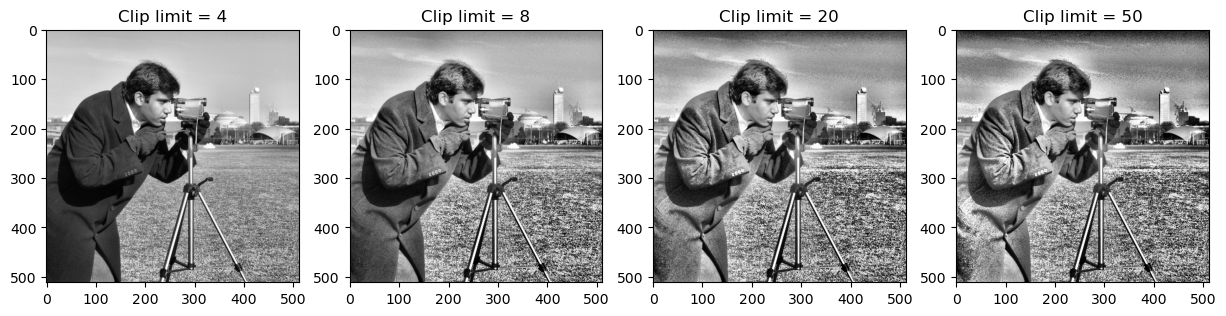

In [27]:
fig, axs = plt.subplots(1,4, figsize = (15, 8))
axs[0].imshow(cl_4, cmap = 'gray')
axs[0].set_title('Clip limit = 4')

axs[1].imshow(cl_8, cmap = 'gray')
axs[1].set_title('Clip limit = 8')

axs[2].imshow(cl_20, cmap = 'gray')
axs[2].set_title('Clip limit = 20')

axs[3].imshow(cl_50, cmap = 'gray')
axs[3].set_title('Clip limit = 50')

print("Varying clip limits")
plt.show()

### e) 
We observe that CLAHE with lower clip value works best. SWAHE sort of alters the original image by a great extent and only the silhoutte of the person is visible. If we split the image into blocks and apply HE, then we get blocks on the image, which results in a distorted output.

### 5.

### a, b)

###  Range for intensity slicing is chosen to be in the range of 120-160 (limits inclusive).

In [28]:
# Range for intensity slicing
r_slice = (120, 160)

# plugging in the values
r_lower = int(r_slice[0])
r_upper = int(r_slice[1])

In [29]:
sliced_wobg = np.zeros((image.shape))
sliced_wbg = np.zeros((image.shape))

# Perform intensity slicing
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if r_lower <= image[i,j] <= r_upper:
            sliced_wobg[i,j], sliced_wbg[i,j] = (255, 255)
        else:
            sliced_wobg[i,j], sliced_wbg[i,j] = (0, image[i,j])

Intensity Slicing on gray scale image


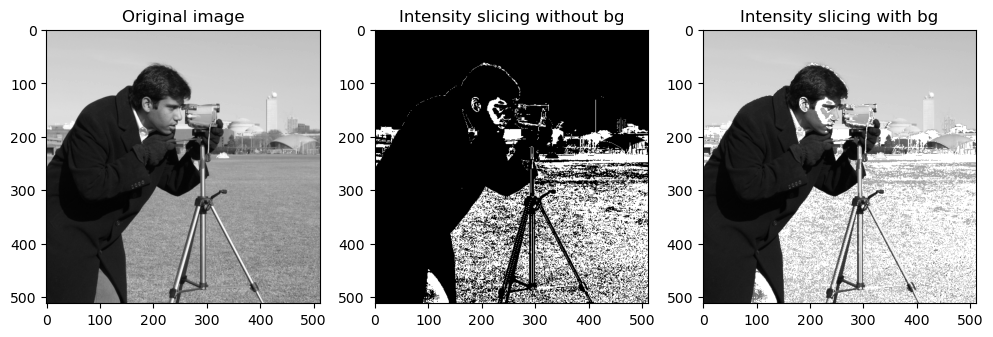

In [30]:
# Display the images
fig, axs = plt.subplots(1,3, figsize = (12, 6))
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title('Original image')

axs[1].imshow(sliced_wobg, cmap = 'gray')
axs[1].set_title("Intensity slicing without bg")

axs[2].imshow(sliced_wbg, cmap = 'gray')
axs[2].set_title("Intensity slicing with bg")

print("Intensity Slicing on gray scale image")
plt.show()

### 6.

### Bit-plane slicing:

In [31]:
# Dictionary to store the bit-planes
bit = {}

for bit_val in range(8):
    plane = np.full((image.shape[0], image.shape[1]), 2 ** bit_val, np.uint8)
    res = cv.bitwise_and(plane, image)
    bit[bit_val] = res

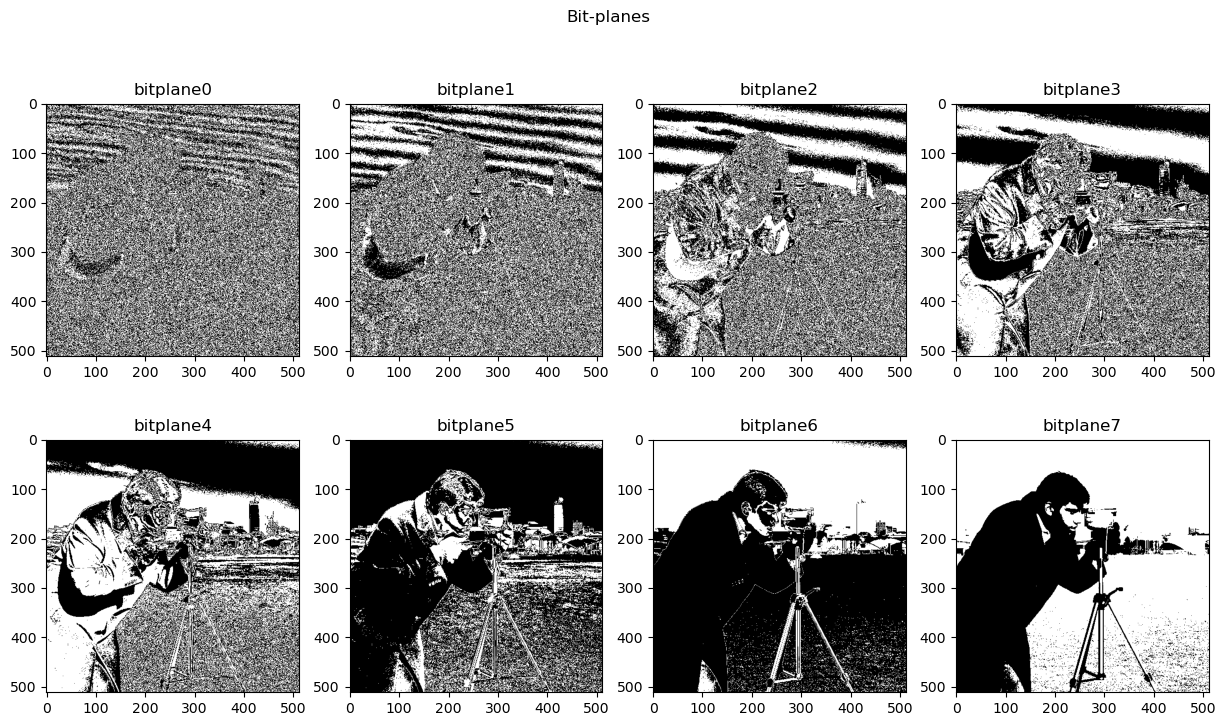

In [32]:
fig, axs = plt.subplots(2,4, figsize = (15, 8))

k = 0
for i in range(2):
    for j in range(4):
        axs[i,j].imshow(bit[k], cmap = 'gray')
        axs[i,j].set_title('bitplane' + str(k))
        k = k + 1
plt.suptitle('Bit-planes')
plt.show()

In [33]:
# Reconstructed images based on the most significant bit planes
reconstructed_img1 = bit[6] + bit[7] 
reconstructed_img2 = bit[5] + bit[6] + bit[7]
reconstructed_img3 = bit[4] + bit[5] + bit[6] + bit[7]

Reconstructing the image based on 3 significant bitplanes


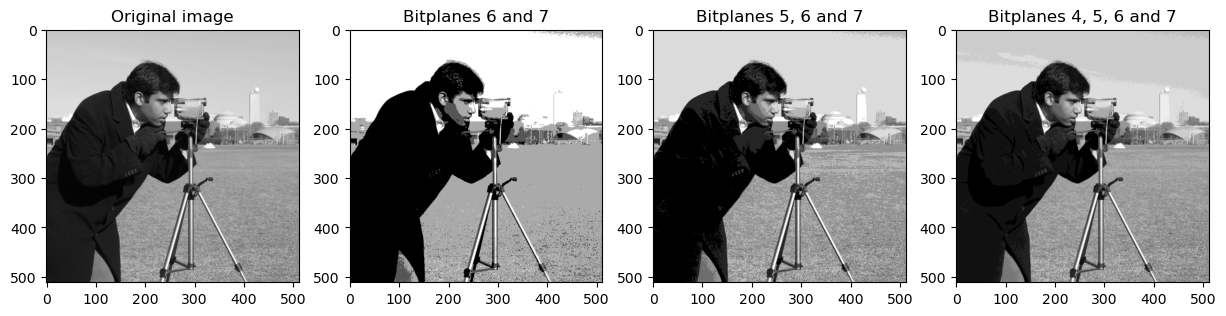

In [34]:
# Display the images
fig, axs = plt.subplots(1,4, figsize = (15, 8))
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title('Original image')

axs[1].imshow(reconstructed_img1, cmap = 'gray')
axs[1].set_title("Bitplanes 6 and 7")

axs[2].imshow(reconstructed_img2, cmap = 'gray')
axs[2].set_title("Bitplanes 5, 6 and 7")

axs[3].imshow(reconstructed_img3, cmap = 'gray')
axs[3].set_title("Bitplanes 4, 5, 6 and 7")

print("Reconstructing the image based on 3 significant bitplanes")
plt.show()

We find that even with just the two most significant bit-planes, we get decent resemblance with the original image. As we start taking more bit-planes while reconstructing the image, we can see that with the 4 most significant bit-planes, we almost get back the original image. Also, we can clearly observe that the clarity gets enhanced as one goes on adding more bit-planes, as shown above.